In [ ]:
!pip install datasets pandas matplotlib seaborn wordcloud nltk transformers scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00


###Loading and Preprocessing the Dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imdb")

for split in dataset.keys():
    print(f"--- {split} Split ---")
    print(dataset[split].column_names)
    print(dataset[split].shape)
    print(dataset[split][0])
    print()

# Basic info about the dataset
print("Dataset Structure: ", dataset)

train_data = dataset['train']
print("Training Data: ", train_data)

missing_values = {column: sum([1 for row in train_data[column] if row is None or row == '']) for column in train_data.column_names}
print("Missing Values: ", missing_values)


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

--- train Split ---
['text', 'label']
(25000, 2)
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Rea

In [ ]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

print(list(newsgroups_train.target_names))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [ ]:
print(f"Number of training posts: {len(newsgroups_train.data)}")
print(f"Number of test posts: {len(newsgroups_test.data)}")

Number of training posts: 11314
Number of test posts: 7532


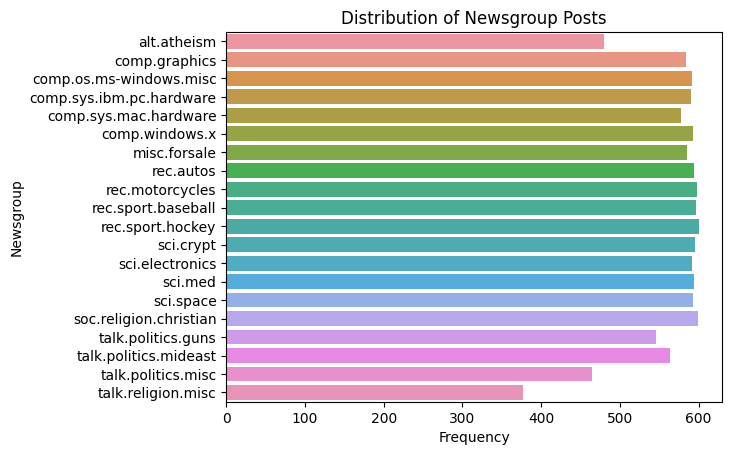

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

targets, frequency = np.unique(newsgroups_train.target, return_counts=True)
targets_str = [newsgroups_train.target_names[i] for i in targets]

sns.barplot(x=frequency, y=targets_str)
plt.xlabel('Frequency')
plt.ylabel('Newsgroup')
plt.title('Distribution of Newsgroup Posts')
plt.show()

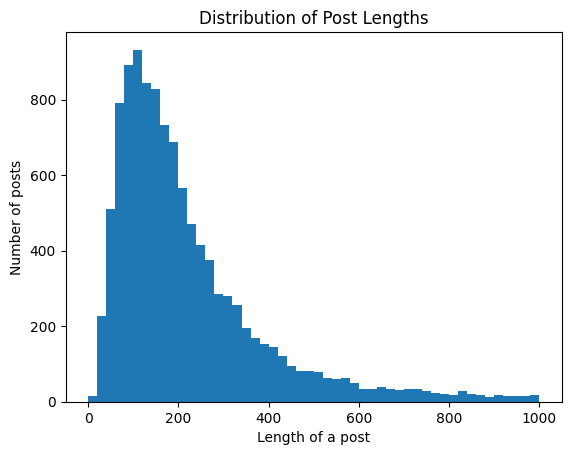

In [ ]:
post_lengths = [len(text.split()) for text in newsgroups_train.data]
plt.hist(post_lengths, bins=50, range=(0, 1000))
plt.xlabel('Length of a post')
plt.ylabel('Number of posts')
plt.title('Distribution of Post Lengths')
plt.show()

###Processing the 20 Newsgroups Dataset

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel, AdamW
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
data = newsgroups_data.data
labels = newsgroups_data.target

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess(texts):
    return [" ".join(tokenizer.tokenize(text)) for text in texts]

train_data = preprocess(train_data)
test_data = preprocess(test_data)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1301 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
model = AutoModel.from_pretrained("distilbert-base-uncased")

def encode_data(model, sentences):
    if mode == "train":
        model.train()
    else:
        model.eval()

    device = next(model.parameters()).device

    encoded_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=256)
    encoded_inputs = {key: val.to(device) for key, val in encoded_inputs.items()}

    with torch.no_grad() if mode != "train" else dummy_context():
        outputs = model(**encoded_inputs)

    return outputs.last_hidden_state[:, 0, :].detach().cpu()


def fine_tune_model(model, train_loader, learning_rate=2e-5, epochs=3):
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state[:, 0, :]
            loss = torch.nn.functional.cross_entropy(embeddings, labels)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        torch.cuda.empty_cache()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
def encode_texts(texts):
    encoded_batch = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=256)
    return encoded_batch['input_ids'], encoded_batch['attention_mask']

input_ids, attention_masks = encode_texts(train_data)
tensor_train_labels = torch.tensor(train_labels)

train_dataset = TensorDataset(input_ids, attention_masks, tensor_train_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
fine_tune_model(model, train_loader)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Loss: 1.8275519237475328
Epoch 2/3, Loss: 1.0026973524345193
Epoch 3/3, Loss: 0.7172717972562775


In [ ]:
train_embeddings = encode_data(model, tokenizer, train_data, mode='train').numpy()
test_embeddings = encode_data(model, tokenizer, test_data, mode='test').numpy()

nn_classifier = KNeighborsClassifier(n_neighbors=5)
nn_classifier.fit(train_embeddings, train_labels)

OutOfMemoryError: ignored

##Label Propagation

In [ ]:
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import string


unlabeled_train_data, unlabeled_test_data = train_test_split(
    newsgroups.data, test_size=0.2, random_state=42)

def preprocess_text(text_data):
    nltk.download('punkt')
    preprocessed_text = []
    for doc in text_data:
        doc = doc.lower()
        doc = doc.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(doc)
        preprocessed_text.append(tokens)
    return preprocessed_text

preprocessed_train = preprocess_text(unlabeled_train_data)
preprocessed_test = preprocess_text(unlabeled_test_data)

model = Word2Vec(sentences=preprocessed_train, vector_size=100, window=5, min_count=1, workers=4)

def document_embedding(doc, model):
    embedding = []
    for word in doc:
        if word in model.wv:
            embedding.append(model.wv[word])
    return np.mean(embedding, axis=0) if embedding else np.zeros(model.vector_size)

unlabeled_train_embeddings = [document_embedding(doc, model) for doc in preprocessed_train]
unlabeled_test_embeddings = [document_embedding(doc, model) for doc in preprocessed_test]

In [ ]:
import numpy as np

# combined_embeddings = np.vstack([train_embeddings, unlabeled_train_embeddings])

# combined_labels = labels

##Train Semi-Supervised Model with Fraction of Data


In [ ]:
def evaluate_model(nn_classifier, test_embeddings, test_labels):
  predicted_labels = nn_classifier.predict(test_embeddings)
  accuracy = accuracy_score(test_labels, predicted_labels)
  return accuracy


fractions = [0.1, 0.3, 0.5, 0.7, 0.9]
fraction_accuracies = {}

for frac in fractions:
    frac_embeddings, _, frac_labels, _ = train_test_split(
        train_embeddings, train_labels, test_size=(1-frac),
        stratify=train_labels, random_state=42
    )

    combined_frac_embeddings = np.vstack([frac_embeddings, unlabeled_train_embeddings])
    combined_frac_labels = np.concatenate([frac_labels, -1 *len(unlabeled_train_embeddings)])

    label_prop_model = LabelPropagation()
    label_prop_model.fit(combined_frac_embeddings, combined_frac_labels)
    propagated_labels = label_prop_model.transduction_

    def train_and_evaluate(embeddings, labels, test_data, test_labels):
        nn_classifier = KNeighborsClassifier(n_neighbors=5)
        nn_classifier.fit(embeddings, labels)

        accuracy = evaluate_model(nn_classifier, test_data, test_labels)
        return accuracy

    frac_accuracy = train_and_evaluate(frac_embeddings, propagated_labels[:len(frac_embeddings)], test_embeddings, test_labels)
    fraction_accuracies[frac] = frac_accuracy
    print(f"Fraction: {frac}, Accuracy: {frac_accuracy}")

In [ ]:
best_fraction = max(fraction_accuracies, key=fraction_accuracies.get)
print(f"The best fraction of labeled data for highest accuracy: {best_fraction}, Accuracy: {fraction_accuracies[best_fraction]}")